In [6]:
import numpy as np
import cPickle as pickle
import h5py
#import hickle as hkl  # this is super faster than pickle, same method to load, dump as pickle
from utils import build_word_to_idx, decode_captions
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open('annotations.pickle', 'rb') as f:
    annotations = pickle.load(f)

In [3]:
captions = annotations['caption']

In [4]:
# 마침표, 쉼표등 학습에 방해가 되는 요소들은 지운다. 
del_idx = []
j = 0
for i in range(len(annotations)):
    sentence = annotations['caption'][i]
    sentence = sentence.replace('.','').replace(',','').replace("'","").replace('"','')
    annotations.set_value(i, 'caption', sentence)
    
    if len(sentence.split(" ")) > 15:
        del_idx.append(i)

# 16개 이상의 단어를 포함한 캡션은 지운다.
print "the number of captions before deleting: %d" %len(annotations)
annotations = annotations.drop(annotations.index[del_idx])
annotations = annotations.reset_index(drop=True)
print "the number of captions after deleting: %d" %len(annotations)

the number of captions before deleting: 414113
the number of captions after deleting: 398782


In [7]:
with h5py.File('data.h5','r') as f:
    data = {}
    for k, v in f.iteritems():
        data[k] = np.asarray(v)

In [8]:
features = data['features1']

In [9]:
features.shape

(500, 14, 14, 512)

In [10]:
annotations.keys()

Index([u'caption', u'file_name', u'id', u'image_id'], dtype='object')

In [11]:
image_file_name = []
id_to_idx = {}
idx_to_id = {}
idx = 0
image_ids = annotations['image_id']
file_names = annotations['file_name']

for image_id, file_name in zip(image_ids, file_names):
    if not image_id in id_to_idx:
        id_to_idx[image_id] = idx
        idx_to_id[idx] = image_id
        idx += 1
        image_file_name.append(file_name)

print "id_to_idx: ", len(id_to_idx)
print "idx_to_id: ", len(idx_to_id)
print "image_file_name: ", len(image_file_name)

id_to_idx:  82783
idx_to_id:  82783
image_file_name:  82783


In [12]:
image_file_name[0:10]

[u'COCO_train2014_000000057870.jpg',
 u'COCO_train2014_000000384029.jpg',
 u'COCO_train2014_000000222016.jpg',
 u'COCO_train2014_000000520950.jpg',
 u'COCO_train2014_000000069675.jpg',
 u'COCO_train2014_000000547471.jpg',
 u'COCO_train2014_000000122688.jpg',
 u'COCO_train2014_000000392136.jpg',
 u'COCO_train2014_000000398494.jpg',
 u'COCO_train2014_000000090570.jpg']

In [19]:
n_examples = 100
image_idxs = np.ndarray(n_examples).astype(np.int32)

for i, image_id in enumerate(image_ids[:n_examples]):
    image_idxs[i] = id_to_idx[image_id]
print image_idxs[-1]

20


In [12]:
word_to_idx, idx_to_word, max_len = build_word_to_idx(annotations['caption'], 200)
print "max length of caption(this shoulde be equal to 15): ", max_len

Filtered words from 24766 to 1255
max length of caption(this shoulde be equal to 15):  15


In [13]:
# caption vector 생성
captions = np.ndarray((n_examples,max_len+2)).astype(np.int32)   # two for <'START'> , <'END'> tokens

for i, annotation in enumerate(annotations['caption'][:n_examples]):
    sentence = annotation
    words = sentence.lower().split(' ')
    n_words = len(words)
    for j in range(max_len+2):
        if j == 0:
            captions[i,j] = word_to_idx['<START>']
        elif j <= n_words:
            if words[j-1] in word_to_idx:
                captions[i,j] = word_to_idx[words[j-1]]
            else:
                captions[i,j] = word_to_idx['<UNK>']
        elif j == n_words+1:
            captions[i,j] = word_to_idx['<END>']
        else:
            captions[i,j] = word_to_idx['<NULL>']            

print "success building caption vectors: ", captions.shape

success building caption vectors:  (2420, 17)


In [16]:
decoded = decode_captions(captions, idx_to_word)

caption vector:  [   1  814  163  492    3 1222 1001 1033  329 1053  253    2    0    0    0
    0    0]
decoded caption:  <START> two men in <UNK> and ties posing for a picture <END>


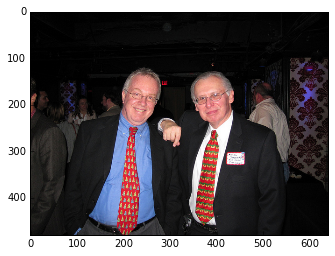

caption vector:  [   1  348  951  311  753  958  623  589 1053 1048    2    0    0    0    0
    0    0]
decoded caption:  <START> an old yellow commercial truck inside of a building <END>


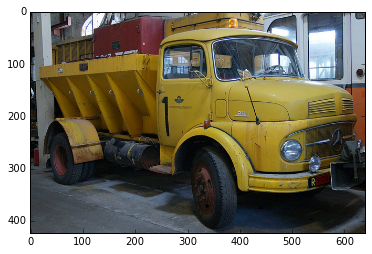

In [41]:
for _ in range(2):
    idx = np.random.randint(0, n_examples)
    print "caption vector: ", captions[idx]
    print "decoded caption: ", decoded[idx]
    img_arr = ndimage.imread('./image_data/train2014/'+image_file_name[image_idxs[idx]])
    plt.imshow(img_arr)
    plt.show()

In [57]:
small_data = {
    'captions': captions,
    'image_idxs': image_idxs,
    'features': features,
    'word_to_idx': word_to_idx,
    'idx_to_word': idx_to_word,
    'id_to_idx': id_to_idx,
    'idx_to_id': idx_to_id,
    'image_file_name': image_file_name,
}

with open('small_data.hkl', 'w') as f:
    hkl.dump(small_data, f)

TypeError: No conversion path for dtype: dtype('<U31')